In [221]:
import math
import matplotlib.pyplot as plt
import numpy as np

y_z = 0.07
f_b = 0.2
R = 0.46
Omega_L0 = 0.6911
Omega_r0 = 0
Omega_m0 = 0.3089
h_0 = 0.6774
#Note the difference between h_0 here and h below 

In [222]:
a_0 = 1.0/1.0               #1.0/(1+z), where z = 0
M_vir_0 = 60758265628.2     #the halo mass at z = 0
M_gas_0 = 17610972.0767     #the gas mass at z = 0
M_tot_0 = 1003534841.64     #the total mass at z = 0
Z_0 = 0.0238180163786       #the metallicity at z = 0
S_0 = 1.0                   #the SFE at z = 0
S_index = -1.5              #the parameter in S(z)
B_0 = 1.0                   #the mass loading factor at z = 0
B_index = 1                 #the parameter in B(z)

The code in the following block does not need to be run, the final data has been saved.

In [ ]:
#define lookback time[Gyr] using the second method
n_integral = 3000              
def f(z):
    s = 1/((1+z)*math.sqrt(((1+z)**2)*(1+Omega_m0*z)-z*(2+z)*Omega_L0))
    return s
def lookbacktime(z):
    h = (z-0)/(2.0000000*n_integral)
    F0 = f(0)+f(z)
    F1 = 0
    F2 = 0
    for j in range(1,2*n_integral):
        x = j*h
        if j%2 == 0:
            F2 = F2+f(x)
        else:
            F1 = F1+f(x)
    return ((h/3)*(F0+(2*F2)+(4*F1)))*9.78*(10**9)/h_0/(10**9)#[Gyr]

#get an array of Z
Redshift_raw = dict(np.load('/huawei/osv1/chenyaoxin/workspace/Data/SnapRedshift.npz'))
#data from TNG300
z_values_raw = np.append(np.delete(np.append(Redshift_raw['Redshift'][13:99],[0])[::-1],[86]),[6.0])
t_values_raw = np.array([lookbacktime(6)-lookbacktime(z) for z in z_values_raw])
delta_t=10**(-4)

flag = 0
z_values = np.array([0])
while flag <= (z_values_raw.shape[0]-2):
    dim = z_values.shape[0]
    z_values = np.delete(z_values, [dim-1])
    n = int((abs(t_values_raw[flag]-t_values_raw[flag+1]))/delta_t)
    z_values = np.append(z_values, np.linspace(z_values_raw[flag],z_values_raw[flag+1],n))
    flag += 1

t_values = np.array([lookbacktime(6)-lookbacktime(z) for z in z_values])
np.savez('/huawei/osv1/chenyaoxin/workspace/Data/redshift-evolution_time10**(-4).npz', redshift = z_values, evolution_time = t_values)

#Draw the pdf of delta_t

In [237]:
Arr = dict(np.load('/huawei/osv1/chenyaoxin/workspace/Data/redshift-evolution_time10**(-5).npz'))
t_values = Arr['evolution_time']
flag = 0
delta_t_true_values = np.array([])
while flag <= (t_values.shape[0]-2):
    delta_t_true_values = np.append(delta_t_true_values, abs(t_values[flag]-t_values[flag+1]))
    flag += 1

plt.hist(delta_t_true_values)

KeyboardInterrupt: 

#Get arrays of redshift and evolution time

In [223]:
#get an array of z and t
Arr = dict(np.load('/huawei/osv1/chenyaoxin/workspace/Data/redshift-evolution_time10**(-4).npz'))
#data from the code of upper block
z_values = Arr['redshift']
t_values = Arr['evolution_time']
num = z_values.shape[0]

#Define the functions and get arrays of SFE, mass loading factor and the halo mass

In [224]:
#define S(z)
def S(z):
    return S_0*((1+z)**S_index)
#define B(z)
def B(z):
    return B_0*((1+z)**B_index)
#define M_vir(z)
def M_vir(z):
    return M_vir_0*math.exp(0-8.2*a_0/13.0+8.2/(13.0*(1+z)))
#get an array of S
S_values=[S(z) for z in z_values]
#get an array of B
B_values=[B(z) for z in z_values]
#get an array of M_vir
M_vir_values=[M_vir(z) for z in z_values]

### calculate delta_M_vir

In [225]:
delta_M_vir_values = np.array([])
flag = 0
while flag <= num-2:
    delta_M_vir_values = np.append(delta_M_vir_values, M_vir_values[flag+1]-M_vir_values[flag])
    flag += 1
    

### calculate delta_M_infall 

In [226]:
delta_M_infall_values = np.array([])
flag = 0
while flag <= num-2:
    result = 0.01*delta_M_vir_values[flag]
    delta_M_infall_values = np.append(delta_M_infall_values, result)
    flag +=1

### calculate M_gas

In [229]:
M_gas_values = np.array([M_gas_0])
flag = 0
while flag <= num-2:
    result1 = 0-(1-R+B_values[flag])*S_values[flag]*M_gas_values[flag]*(t_values[flag+1]-t_values[flag])+delta_M_infall_values[flag]
    result2 = M_gas_values[flag]+result1
    M_gas_values = np.append(M_gas_values, result2)
    flag +=1

### calculate M_tot

In [230]:
M_tot_values = np.array([M_tot_0])
flag = 0
while flag <= num-2:
    result1 = delta_M_infall_values[flag]-B_values[flag]*S_values[flag]*M_gas_values[flag]*(t_values[flag+1]-t_values[flag])
    result2 = M_tot_values[flag]+result1
    M_tot_values = np.append(M_tot_values,result2)
    flag += 1


### calculate M_star

In [231]:
M_star_values = np.array([])
flag = 0
while flag <= num-1:
    M_star_values = np.append(M_star_values, M_tot_values[flag]-M_gas_values[flag])
    flag += 1

### calculate SFR

In [232]:
SFR_values = np.array([])
flag = 0
while flag <= num-1:
    SFR_values = np.append(SFR_values, S_values[flag]*M_gas_values[flag]/(10**9))
    flag += 1

### calculate metallicity Z

In [233]:
Z_values = np.array([Z_0])
flag = 0
while flag <= num-2:
    result1 = y_z*(1-R)*S_values[flag]*(t_values[flag+1]-t_values[flag])-(Z_values[flag]*delta_M_infall_values[flag]/M_gas_values[flag])
    result2 = Z_values[flag]+result1
    Z_values = np.append(Z_values, result2)
    flag += 1
    

### judgement

In [234]:
flag = 0
while flag <= num-1:
    if M_star_values[flag]>0 and Z_values[flag]>0:
        flag += 1
    else:
        break
judge_number = flag-1

### figure

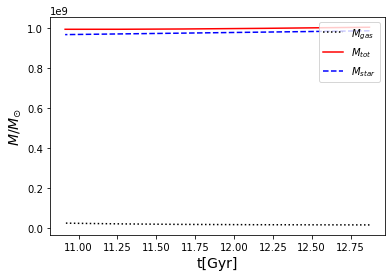

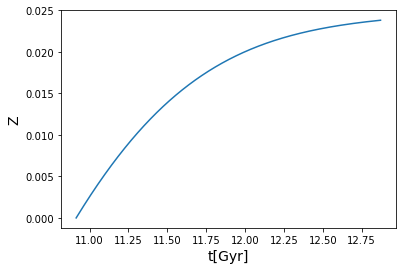

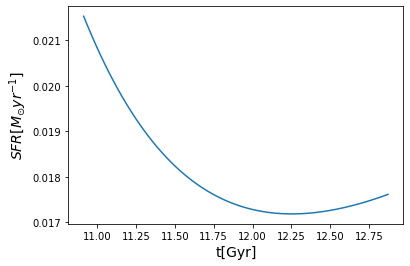

In [235]:

#M
plt.figure('The first figure')
plt.plot(t_values[0:judge_number],M_gas_values[0:judge_number],color="black",linestyle=":",label='${M_{gas}}$')
plt.plot(t_values[0:judge_number],M_tot_values[0:judge_number],color="red",linestyle="-",label='${M_{tot}}$')
plt.plot(t_values[0:judge_number],M_star_values[0:judge_number],color="blue",linestyle="--",label='${M_{star}}$')
plt.xlabel("t[Gyr]",fontsize=14)
plt.ylabel("${M}$/${M_{\odot}}$",fontsize=14)
plt.legend(loc=1)
plt.savefig('/huawei/osv1/chenyaoxin/workspace/Figure/working-from z=0/M.pdf')

#Z
plt.figure('The second figure')
plt.plot(t_values[0:judge_number],Z_values[0:judge_number])
plt.xlabel("t[Gyr]",fontsize=14)
plt.ylabel("Z",fontsize=14)
plt.savefig('/huawei/osv1/chenyaoxin/workspace/Figure/working-from z=0/Z.pdf')

#SFR
plt.figure('The third figure')
plt.plot(t_values[0:judge_number],SFR_values[0:judge_number])
plt.xlabel("t[Gyr]",fontsize=14)
plt.ylabel("${SFR}$${[M_{\odot}yr^{-1}]}$",fontsize=14)
plt.savefig('/huawei/osv1/chenyaoxin/workspace/Figure/working-from z=0/SFR.pdf') 

### Print

In [202]:
print(M_star_values[0:judge_number].shape)
print(z_values.shape)

(118617,)
(128589,)


### main sequence

0


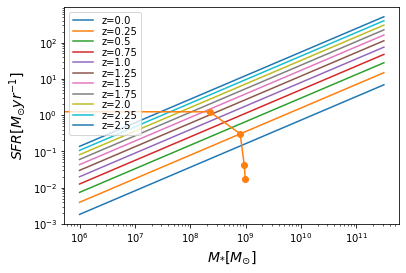

In [236]:
import math
import matplotlib.pyplot as plt
import numpy as np

A_11 = 3.24 #M_sun/yr
beta = -0.35
alpha = 3.45

def SFR(M_star,z):
    s = A_11*((M_star*1.00/(10**11))**(1+beta))*((1+z)**alpha)
    return s

z_values_obs = np.array([0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5])

M_star_values_obs = np.array([10**6,10**6.5,10**7,10**7.5,10**8,10**8.5,10**9,10**9.5,10**10,10**10.5,10**11,10**11.5])

#get an array of z and t
Arr = dict(np.load('/huawei/osv1/chenyaoxin/workspace/Data/redshift-evolution_time10**(-4).npz'))
#data from the code of upper block
z_values = Arr['redshift']
t_values = Arr['evolution_time']
num = z_values.shape[0]

flag1 = 0
flag2 = 0
index = np.array([])
z_values_ele = np.array([])
while flag1 <= z_values_obs.shape[0]-1:
    while flag2 <= z_values.shape[0]-1:
        if z_values[flag2] >= z_values_obs[flag1]:
            index = np.append(index, flag2)
            z_values_ele = np.append(z_values_ele, z_values[flag2])
            break
        flag2 += 1
    flag1 += 1
print(int(index[0]))

    
plt.figure('The fourth figure')
flag = 0
SFR_values_obs = np.array([])
while flag <= z_values_obs.shape[0]-1:
    SFR_values_obs = np.array([SFR(M_star,z_values_obs[flag]) for M_star in M_star_values_obs])
    plt.loglog(M_star_values_obs,SFR_values_obs,label='z='+str(z_values_obs[flag]))
    flag += 1

flag = 0
M_star_values_model = np.array([])
SFR_values_model = np.array([])
while flag <= z_values_obs.shape[0]-1:
    M_star_values_model = np.append(M_star_values_model, M_star_values[int(index[flag])])
    SFR_values_model = np.append(SFR_values_model, SFR_values[int(index[flag])])
    flag += 1
plt.loglog(M_star_values_model, SFR_values_model, '-o')

plt.xlabel("${M_{*}}$$[{M_{\odot}}]$",fontsize=14)
plt.ylabel("${SFR}$${[M_{\odot}yr^{-1}]}$",fontsize=14)
plt.legend(loc=2,labelspacing=0.05)